![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

<h1>Package Installation</h1>

<!-- Link to official GitHub repository -->
<p>
  Official Repository:
  <a href="https://github.com/JohnSnowLabs/johnsnowlabs" target="_blank">
    https://github.com/JohnSnowLabs/johnsnowlabs
  </a>
</p>

<!-- License setup instructions -->
<p>
  Keep your <strong>license keys</strong> in a JSON file and point to it using the
  <code>json_license_path</code> argument when starting the Spark session.
</p>

<!-- Visual NLP configuration note -->
<p>
  Set <code>visual=True</code> while starting the Spark session to install and make
  <strong>Visual NLP libraries</strong> available.
</p>

<!-- Restart note -->
<p>
  ⚠️ <strong>Important:</strong> After installing the library, make sure to
  <strong>RESTART your session</strong> before running Spark again.
</p>

<!-- End of notebook cell -->

In [ ]:
!pip install -q johnsnowlabs

In [ ]:
from johnsnowlabs import nlp, visual, medical

nlp.install(refresh_install=True, visual=True, json_license_path="./spark_nlp_for_healthcare_spark_ocr_10538.json")

In [ ]:
### RESTART SESSION !!!!

In [1]:
from johnsnowlabs import visual, nlp

spark = nlp.start(visual=True, hardware_target="gpu", json_license_path="./spark_nlp_for_healthcare_spark_ocr_10538.json")

spark

👌 License info detected in file ./spark_nlp_for_healthcare_spark_ocr_10538.json
🤓 Looks like you are missing some jars, trying fetching them ...
👌 Detected license file /workspace/spark-nlp-workshop/tutorials/Certification_Trainings/Training_Notebooks & Slides/Visual_NLP/spark_nlp_for_healthcare_spark_ocr_10538.json
🙆 JSL Home setup in /root/.johnsnowlabs
👌 License info detected in file ./spark_nlp_for_healthcare_spark_ocr_10538.json


25/10/22 19:05:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


👌 Launched gpu optimized session with with: 🚀Spark-NLP==6.1.3, 💊Spark-Healthcare==6.1.1, 🕶Spark-OCR==6.1.0, running on ⚡ PySpark==3.4.0


<h1>OCR Feature Overview</h1>

<!-- Short summary -->
<p>
  This notebook describes how to use <strong>OCR (Optical Character Recognition)</strong> features
  to extract text from <strong>Images</strong> and <strong>PDF documents</strong>.
  It demonstrates how to use different <em>Detection</em> and <em>Recognition</em> stages together.
</p>

<!-- Stage list -->
<h2>Stages Covered in this Notebook</h2>
<ul>
  <li>BinaryToImage</li>
  <li>PdfToImage</li>
  <li>ImageTextDetectorV2</li>
  <li>ImageTextDetector (Scala)</li>
  <li>ImageToText</li>
  <li>ImageToTextV2 (printed & handwritten)</li>
  <li>ImageToTextV3</li>
  <li>ImageDrawRegions</li>
</ul>

<!-- End of introduction cell -->

In [2]:
# 📦 Spark OCR Imports
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import *

# ⚡ Spark NLP Core
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline

# 🔗 Spark ML
from pyspark.ml import Pipeline, PipelineModel
import pyspark.sql.functions as F

# 🧩 Spark NLP for Healthcare (JSL)
import sparknlp_jsl
from sparknlp_jsl.annotator import *

from IPython.display import display, Markdown

import pkg_resources

## ImageToText Parameters

**pageSegMode** – Page Segmentation Mode.  
**pageIteratorLevel** – Page Iterator Level.  
**language** – Language used for text recognition.  
**modelData** – Path or identifier for the OCR model data.  
**includeConfidence** – Enables or disables computation of confidence scores.  
**confidenceCol** – Name of the output column containing confidence values.  
**confidenceThreshold** – Minimum confidence threshold for recognized text.  
**ignoreResolution** – Ignores resolution information from image metadata.  
**ocrParams** – Additional OCR parameters in `key=value` format.  
**positionsCol** – Name of the output column containing text positions.  
**pdfCoordinates** – Converts text coordinates to PDF coordinate space.  
**withSpaces** – Includes spaces in output text positions.  
**keepLayout** – Preserves the original text layout in the OCR output.  
**outputSpaceCharacterWidth** – Defines the width of space characters (in pts) when keeping layout.

In [3]:
image_path = pkg_resources.resource_filename('sparkocr', 'resources/ocr/images/check.jpg')
image_example_df = spark.read.format("binaryFile").load(image_path).cache()

image_example_df.columns

['path', 'modificationTime', 'length', 'content']

In [4]:
binary_to_image = BinaryToImage()\
      .setInputCol("content") \
      .setOutputCol("image")

ocr = ImageToText() \
      .setInputCol("image") \
      .setOutputCol("text") \
      .setConfidenceThreshold(65) \
      .setKeepLayout(False) \
      .setWithSpaces(False)

image_to_text_pipeline = PipelineModel(stages=[
    binary_to_image,
    ocr
])

In [5]:
result = image_to_text_pipeline.transform(image_example_df)
result.columns

['image',
 'path',
 'modificationTime',
 'length',
 'pagenum',
 'confidence',
 'exception',
 'text',
 'positions']

Detected 82 diacritics



    Image #0:
    Origin: file:/usr/local/lib/python3.12/dist-packages/sparkocr/resources/ocr/images/check.jpg
    Resolution: 199 dpi
    Width: 582 px
    Height: 744 px
    Mode: 10
    Number of channels: 1


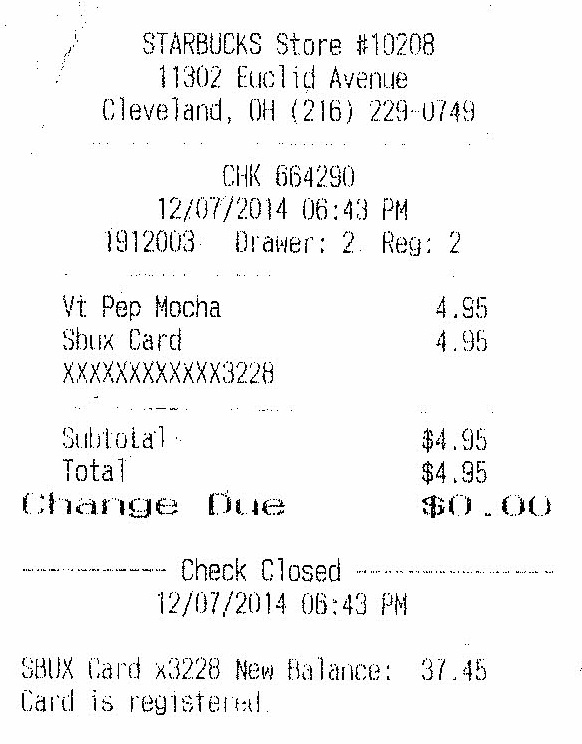

In [6]:
display_images(result, "image")

In [7]:
print("\n".join([row.text for row in result.select("text").collect()]))

STARBUCKS Store #19208
11902 Euclid Avenue
Cleveland, OH (216) 229-U749

CHK 664250
12/07/2014 06:43 PM
112003. Drawer: 2. Reg: 2

oBUX Card «3228 New Balance: 37.45
Card is registertd



Detected 82 diacritics


In [8]:
binary_to_image = BinaryToImage()\
      .setInputCol("content") \
      .setOutputCol("image")

ocr = ImageToText() \
      .setInputCol("image") \
      .setOutputCol("text") \
      .setConfidenceThreshold(65) \
      .setPageIteratorLevel(PageIteratorLevel.SYMBOL) \
      .setPageSegMode(PageSegmentationMode.AUTO_OSD) \
      .setKeepLayout(False) \
      .setWithSpaces(True)

image_to_text_pipeline = PipelineModel(stages=[
    binary_to_image,
    ocr
])


In [9]:
result = image_to_text_pipeline.transform(image_example_df)
result.columns

['image',
 'path',
 'modificationTime',
 'length',
 'pagenum',
 'confidence',
 'exception',
 'text',
 'positions']

In [10]:
print("\n".join([row.text for row in result.select("text").collect()]))


STARBUCKS Store #19208
11902 Euclid Avenue
Cleveland, OH (216) 229-U749
CHK 664250
12/07/2014 06:43 PM
112003. Drawer: 2. Reg: 2
¥t Pep Mocha 4.95
Sbux Card 4.95
AXKANRKAXERAK, 3228
Subtotal $4.95
Total $4.95
Change Cue BOC
- Check Closed ~
“12/01/2014 06:43 py
oBUX Card «3228 New Balance: 37.45
Card is registertd


OSD: Weak margin (4.53), horiz textlines, not CJK: Don't rotate.
Detected 82 diacritics


## ImageToText - PDF Example

25/10/22 19:06:11 WARN FileSystemFontProvider: New fonts found, font cache will be re-built
25/10/22 19:06:11 WARN FileSystemFontProvider: Building on-disk font cache, this may take a while
25/10/22 19:06:11 WARN FileSystemFontProvider: Finished building on-disk font cache, found 22 fonts
25/10/22 19:06:11 WARN PDType1Font: Using fallback font LiberationSans for base font Times-Roman
25/10/22 19:06:11 WARN PDType1Font: Using fallback font LiberationSans for base font Times-Bold
25/10/22 19:06:11 WARN PDType1Font: Using fallback font LiberationSans for base font Times-Italic
25/10/22 19:06:11 WARN PDType1Font: Using fallback font LiberationSans for base font Times-BoldItalic
25/10/22 19:06:11 WARN PDType1Font: Using fallback font LiberationSans for base font Helvetica
25/10/22 19:06:11 WARN PDType1Font: Using fallback font LiberationSans for base font Helvetica-Bold
25/10/22 19:06:11 WARN PDType1Font: Using fallback font LiberationSans for base font Helvetica-Oblique
25/10/22 19:06:11 W


    Image #0:
    Origin: file:/workspace/spark-nlp-workshop/tutorials/Certification_Trainings/Training_Notebooks & Slides/Visual_NLP/data/visual/pdfs/PDF_Deid_Deidentification_0.pdf
    Resolution: 300 dpi
    Width: 2480 px
    Height: 3507 px
    Mode: 10
    Number of channels: 1


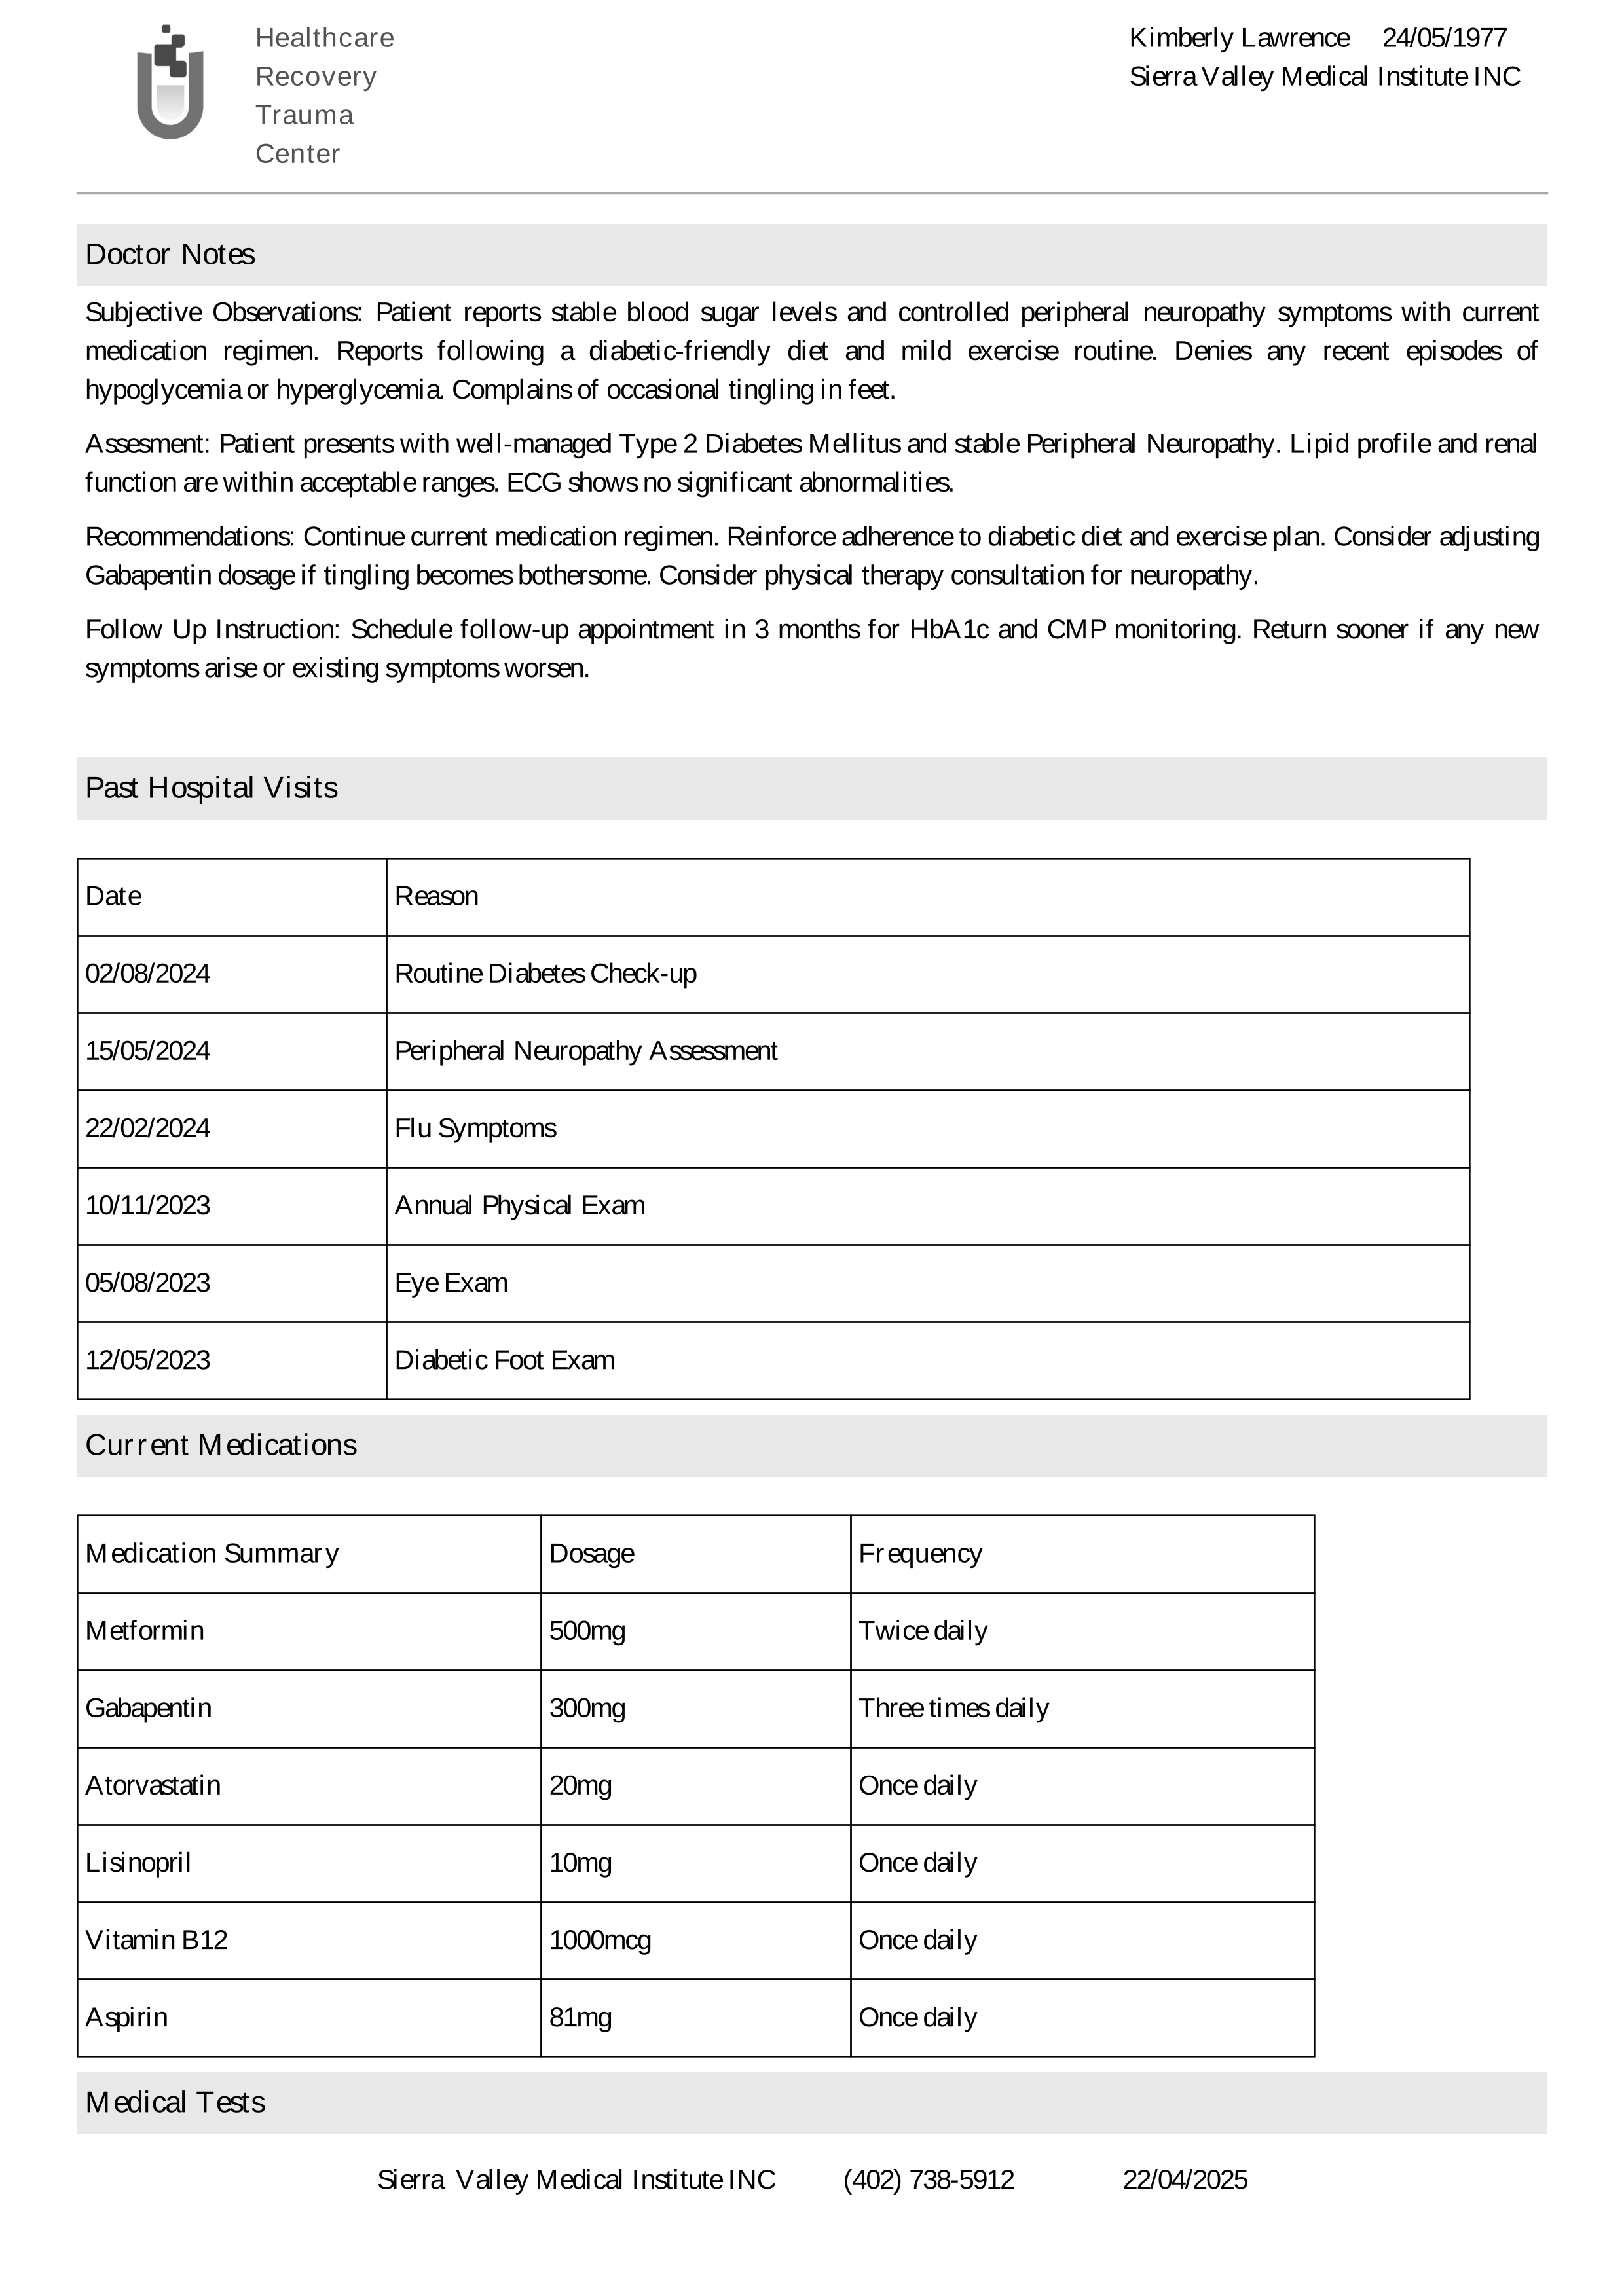


    Image #1:
    Origin: file:/workspace/spark-nlp-workshop/tutorials/Certification_Trainings/Training_Notebooks & Slides/Visual_NLP/data/visual/pdfs/PDF_Deid_Deidentification_0.pdf
    Resolution: 300 dpi
    Width: 2480 px
    Height: 3507 px
    Mode: 10
    Number of channels: 1


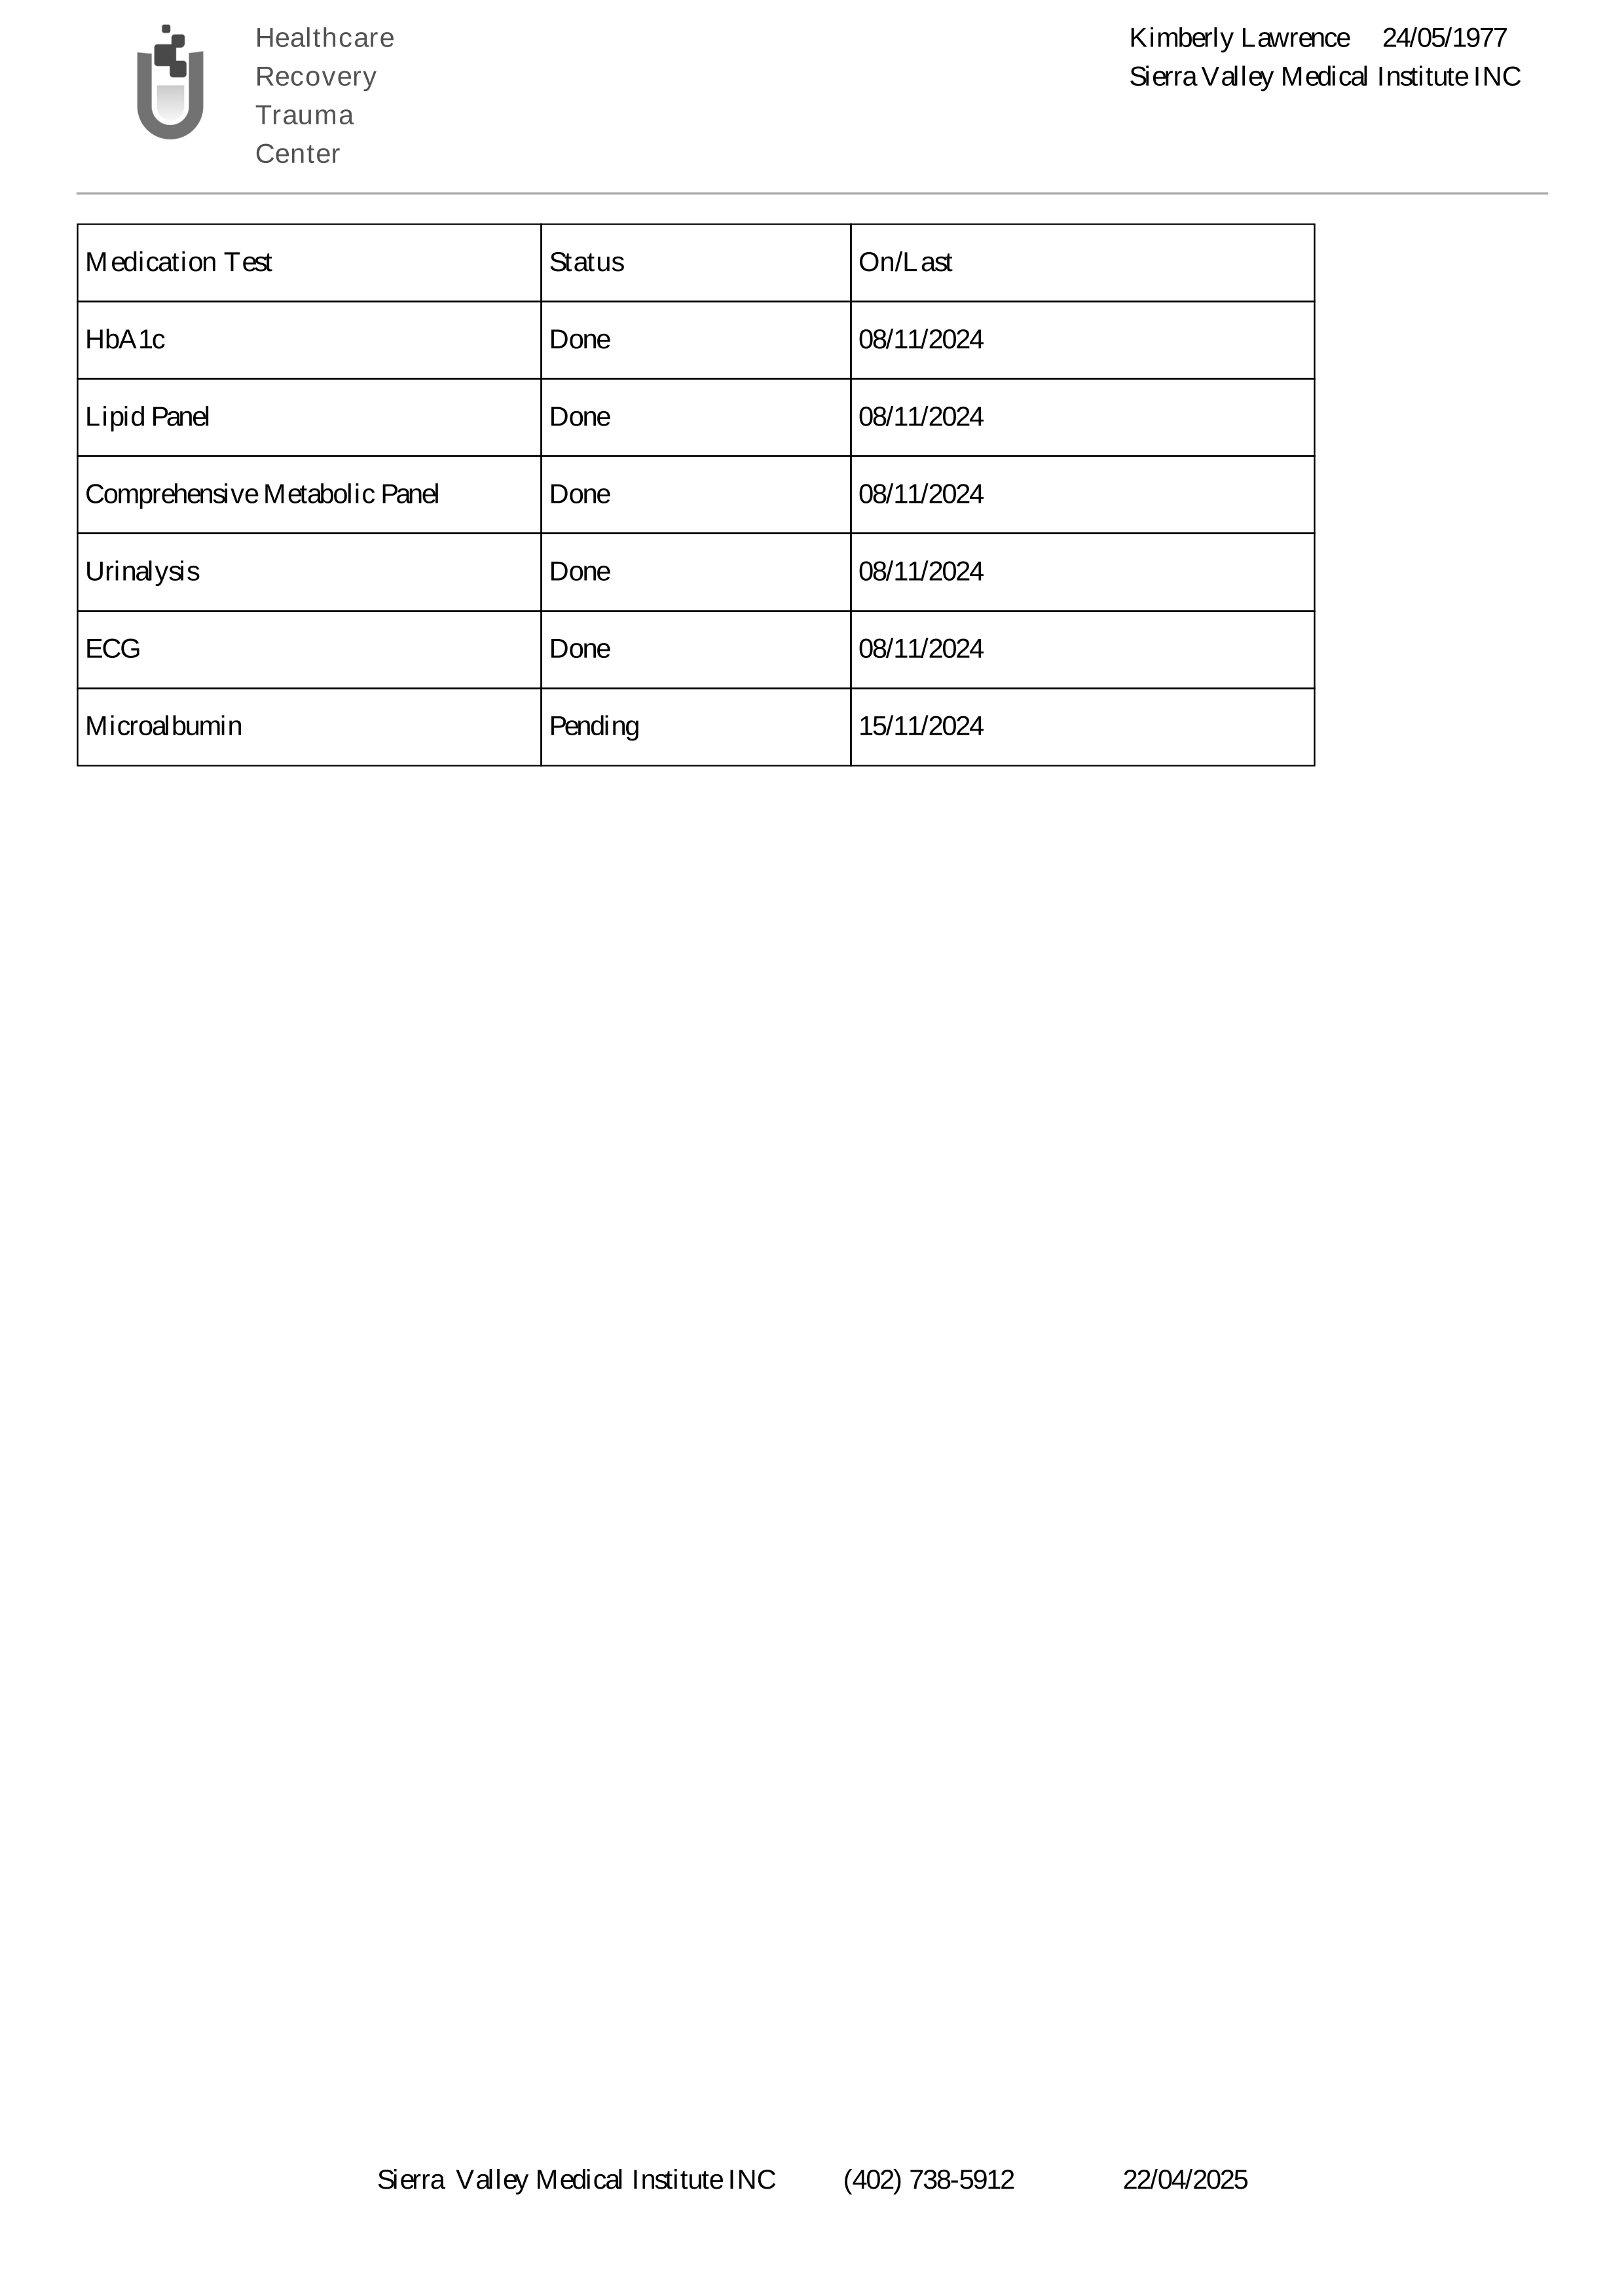


    Image #2:
    Origin: file:/workspace/spark-nlp-workshop/tutorials/Certification_Trainings/Training_Notebooks & Slides/Visual_NLP/data/visual/pdfs/PDF_Deid_Deidentification_0.pdf
    Resolution: 300 dpi
    Width: 2480 px
    Height: 3507 px
    Mode: 10
    Number of channels: 1


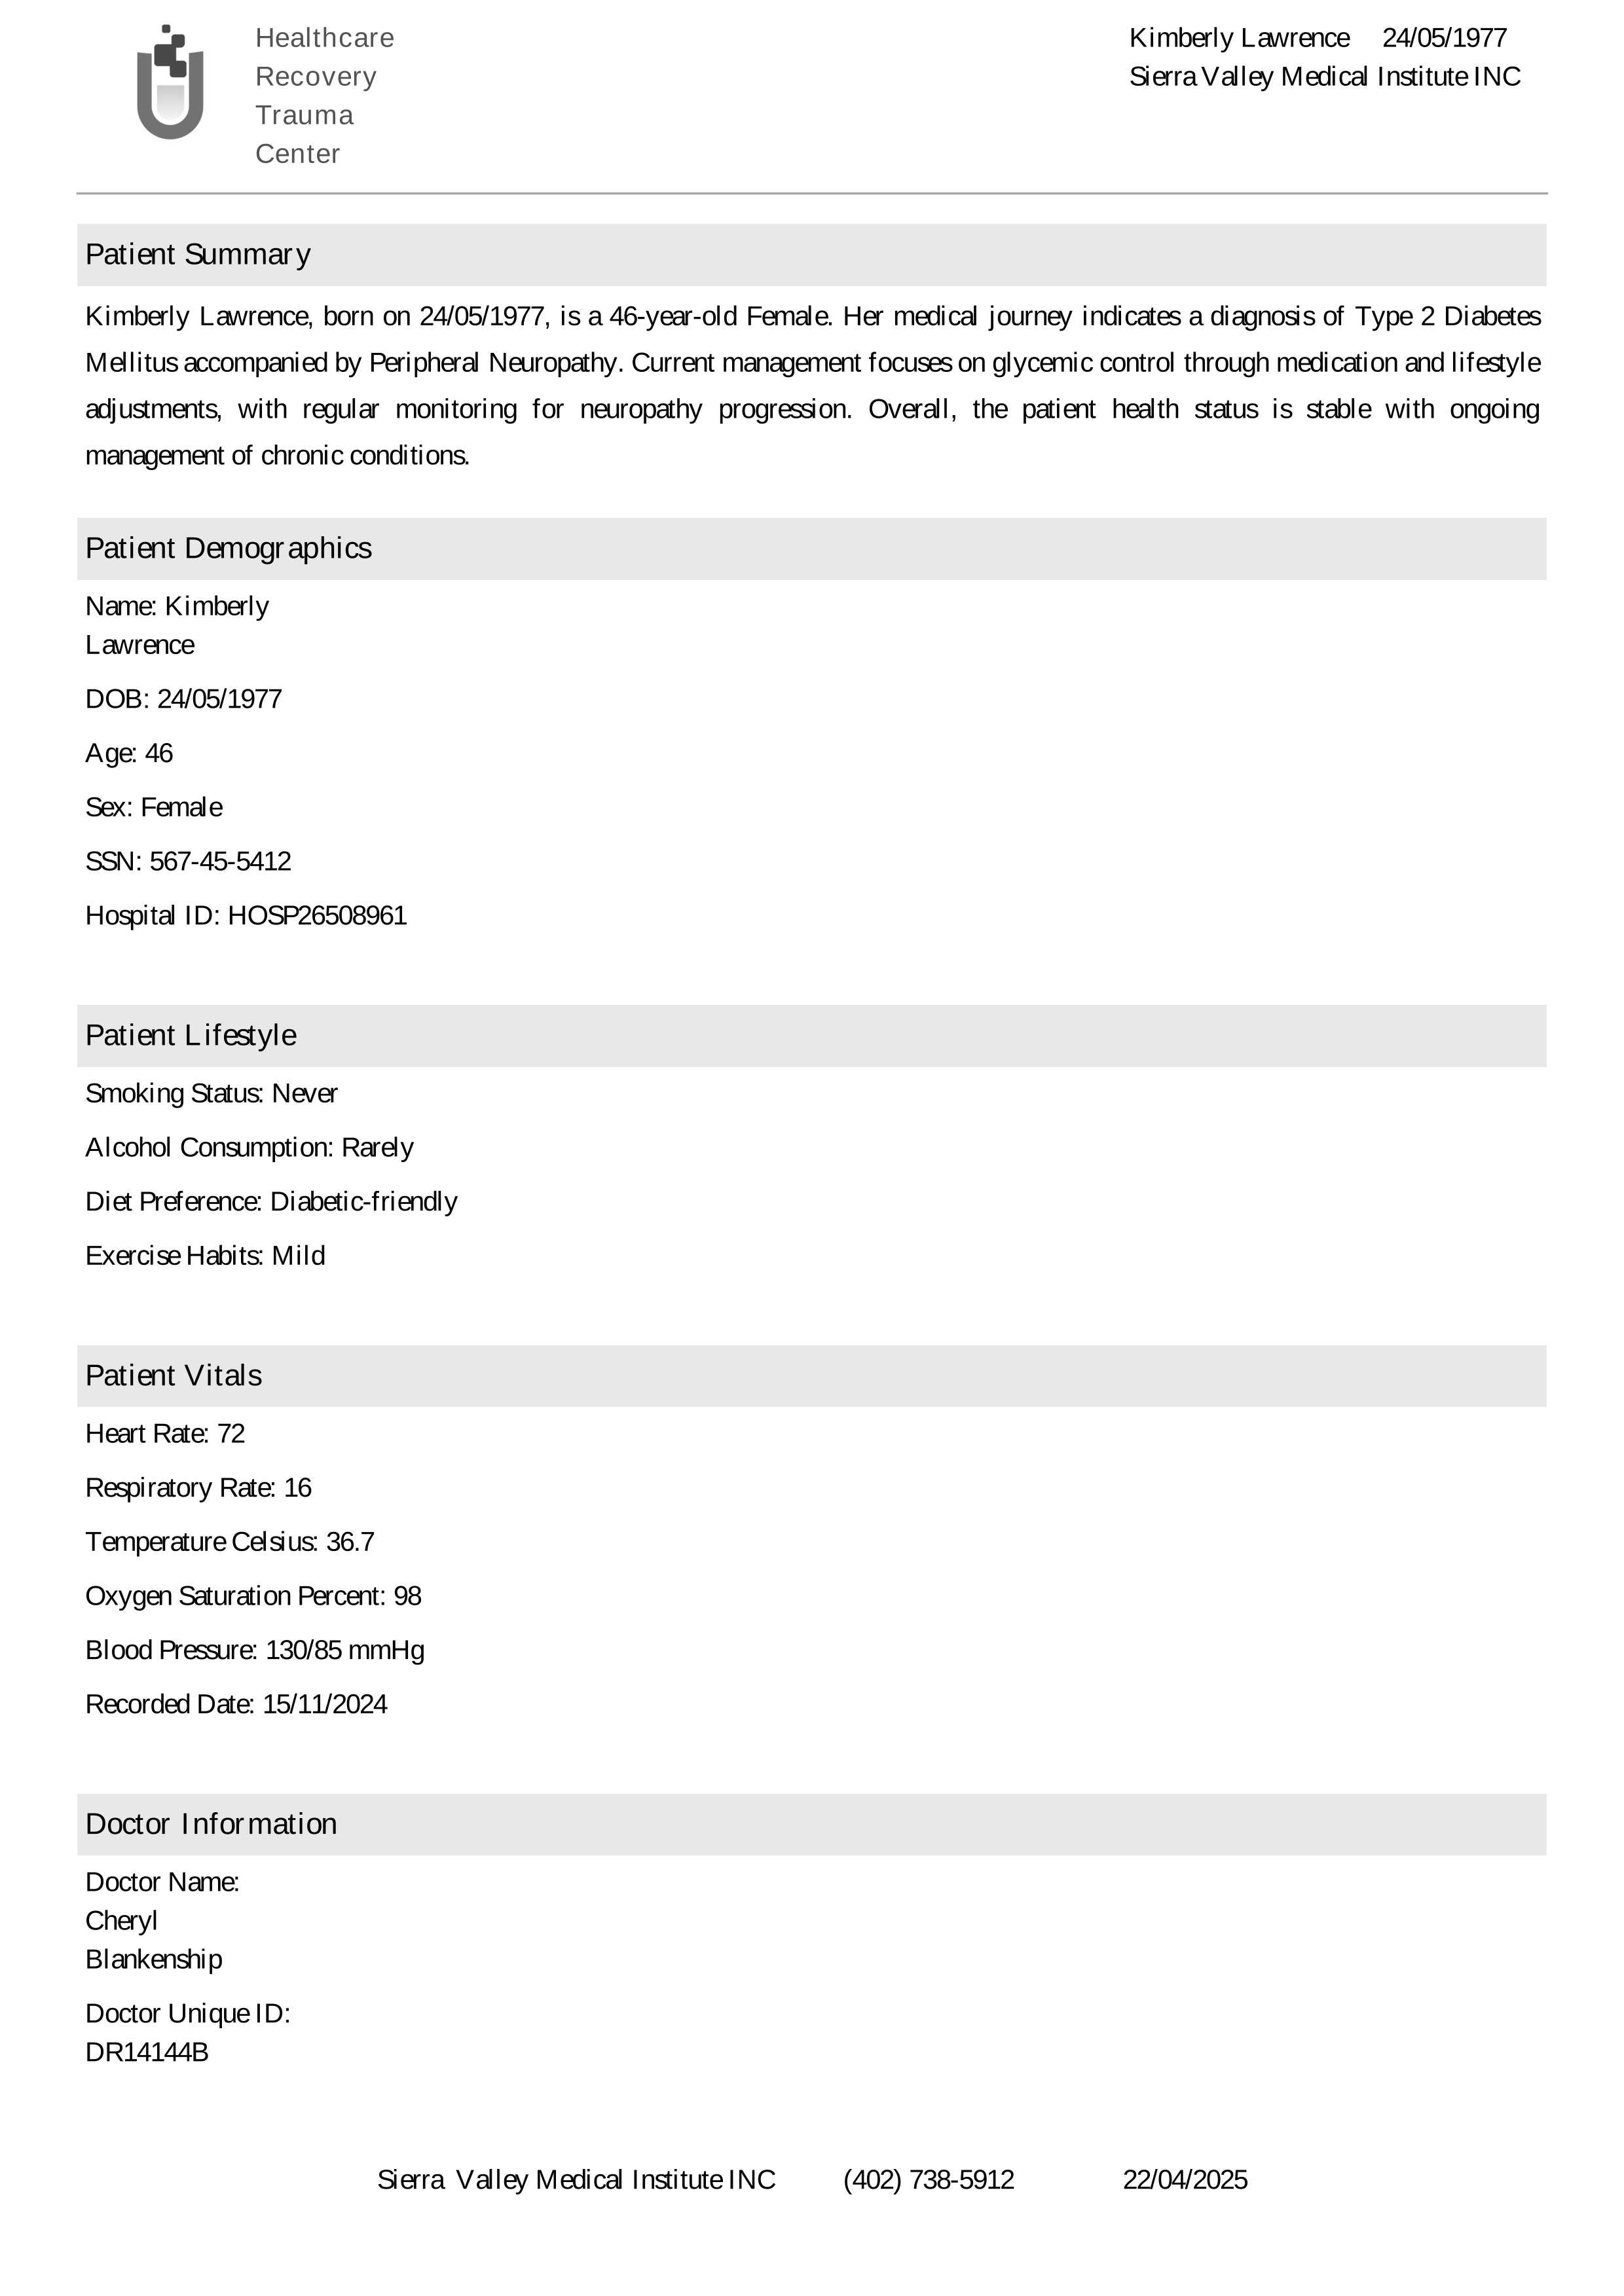

In [11]:
pdf_path = "./data/visual/pdfs/PDF_Deid_Deidentification_0.pdf"

pdf_example_df = spark.read.format("binaryFile").load(pdf_path)

display_pdf(pdf_example_df, field="content", width=300, show_meta=True)

In [12]:
pdf_to_image = PdfToImage() \
    .setInputCol("content") \
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

ocr = ImageToText() \
      .setInputCol("image") \
      .setOutputCol("text") \
      .setConfidenceThreshold(65) \
      .setPageIteratorLevel(PageIteratorLevel.SYMBOL) \
      .setPageSegMode(PageSegmentationMode.SPARSE_TEXT) \
      .setKeepLayout(False) \
      .setWithSpaces(True)

pdf_ocr_pipeline = PipelineModel(stages=[
    pdf_to_image,
    ocr
])

In [13]:
result = pdf_ocr_pipeline.transform(pdf_example_df)
result.columns

['path',
 'modificationTime',
 'length',
 'image',
 'total_pages',
 'pagenum',
 'documentnum',
 'confidence',
 'exception',
 'text',
 'positions']

In [14]:
for item in result.orderBy("path", "pagenum").toLocalIterator():
  data = item.asDict()

  print(f"Pagenum : {data['pagenum']}", end="\n\n")

  print(data["text"], end="\n\n")

  print("--" * 50, end="\n\n")

25/10/22 19:06:17 WARN PDType1Font: Using fallback font LiberationSans for Helvetica-Bold
25/10/22 19:06:17 WARN PDType1Font: Using fallback font LiberationSans for Times-Roman
25/10/22 19:06:17 WARN PDType1Font: Using fallback font LiberationSans for Times-Bold
[Stage 13:>                                                         (0 + 1) / 1]

Pagenum : 0


Healthcare
Kimberly Lawrence 24/05/1977
Recovery
Sierra Valley Medical Institute INC
Trauma
0
Center
Patient Summary
Kimberly Lawrence, born on 24/05/1977, is a 46-year-old Female. Her medical journey indicates a diagnosis of Type 2 Diabetes
Mellitus accompanied by Peripheral Neuropathy. Current management focuses on glycemic control through medication and lifestyle
adjustments, with regular monitoring for neuropathy progression. Overall, the patient health status is stable with ongoing
management of chronic conditions.
Patient Demogr aphics
Name: Kimberly
Lawrence
DOB: 24/05/1977
Age: 46
Sex: Female
SSN: 567-45-5412
Hospital |D: HOSP26508961
Patient Lifestyle
Smoking Status: Never
Alcohol Consumption: Rarely
Diet Preference: Diabetic-friendly
Exercise Habits: Mild
Patient Vitals
Heart Rate: 72
Respiratory Rate: 16
Temperature Celsius: 36.7
Oxygen Saturation Percent: 98
Blood Pressure: 130/85 mmHg
Recorded Date: 15/11/2024
Doctor Information
Doctor Name:
Cheryl
Blankenshi

## ImageToHOCR - PDF Example

In [15]:
pdf_to_image = PdfToImage() \
    .setInputCol("content") \
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR) \
    .setResolution(300)

ocr = ImageToHocr() \
    .setInputCol("image") \
    .setOutputCol("hocr") \
    .setIgnoreResolution(False)

tokenizer = HocrTokenizer() \
    .setInputCol("hocr") \
    .setOutputCol("token") \

draw_annotations = ImageDrawAnnotations() \
    .setInputCol("image") \
    .setInputChunksCol("token") \
    .setOutputCol("image_with_annotations") \
    .setFilledRect(False) \
    .setFontSize(20)

hocr_pdf_pipeline = PipelineModel(stages=[
    pdf_to_image,
    ocr,
    tokenizer,
    draw_annotations
])

In [16]:
result = hocr_pdf_pipeline.transform(pdf_example_df)
result.columns

['path',
 'modificationTime',
 'length',
 'image',
 'total_pages',
 'pagenum',
 'documentnum',
 'hocr',
 'token',
 'image_with_annotations',
 'exception']

19:07:26, INFO generated new fontManager
25/10/22 19:07:27 WARN PDType1Font: Using fallback font LiberationSans for Helvetica-Bold
25/10/22 19:07:27 WARN PDType1Font: Using fallback font LiberationSans for Times-Roman
25/10/22 19:07:27 WARN PDType1Font: Using fallback font LiberationSans for Times-Bold
                                                                                

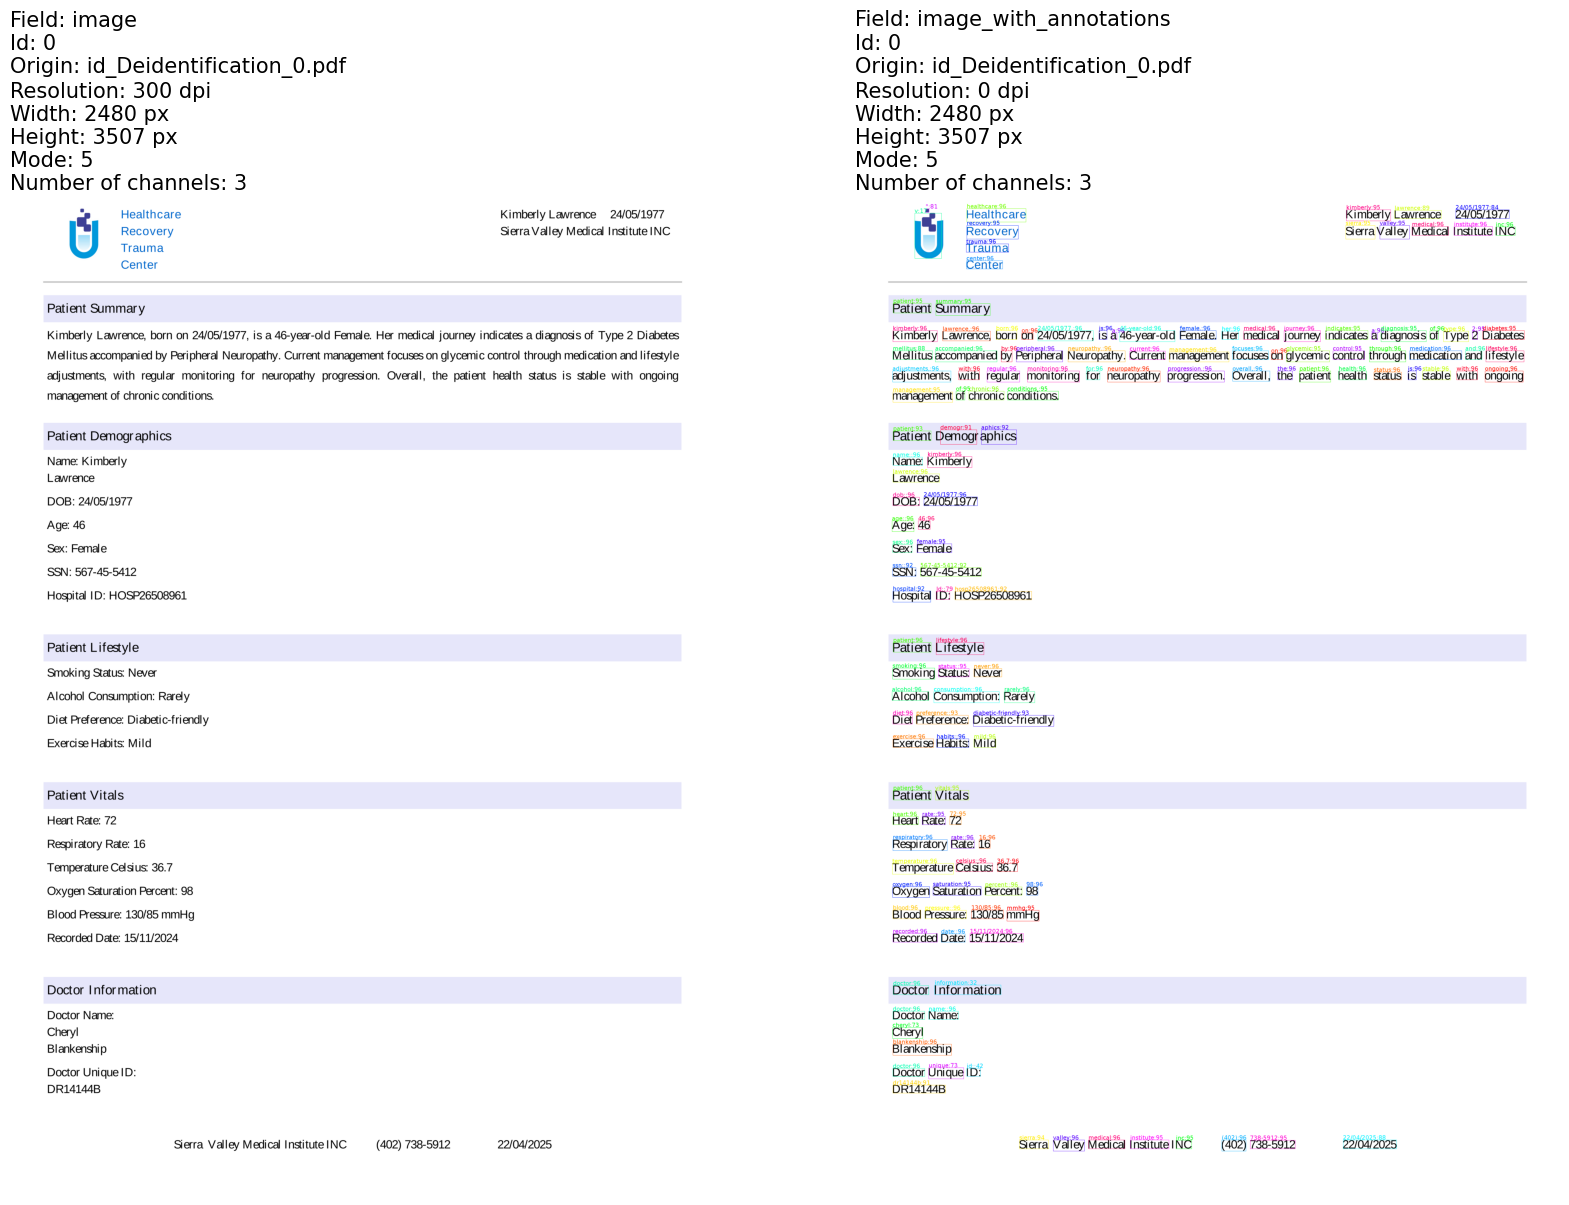

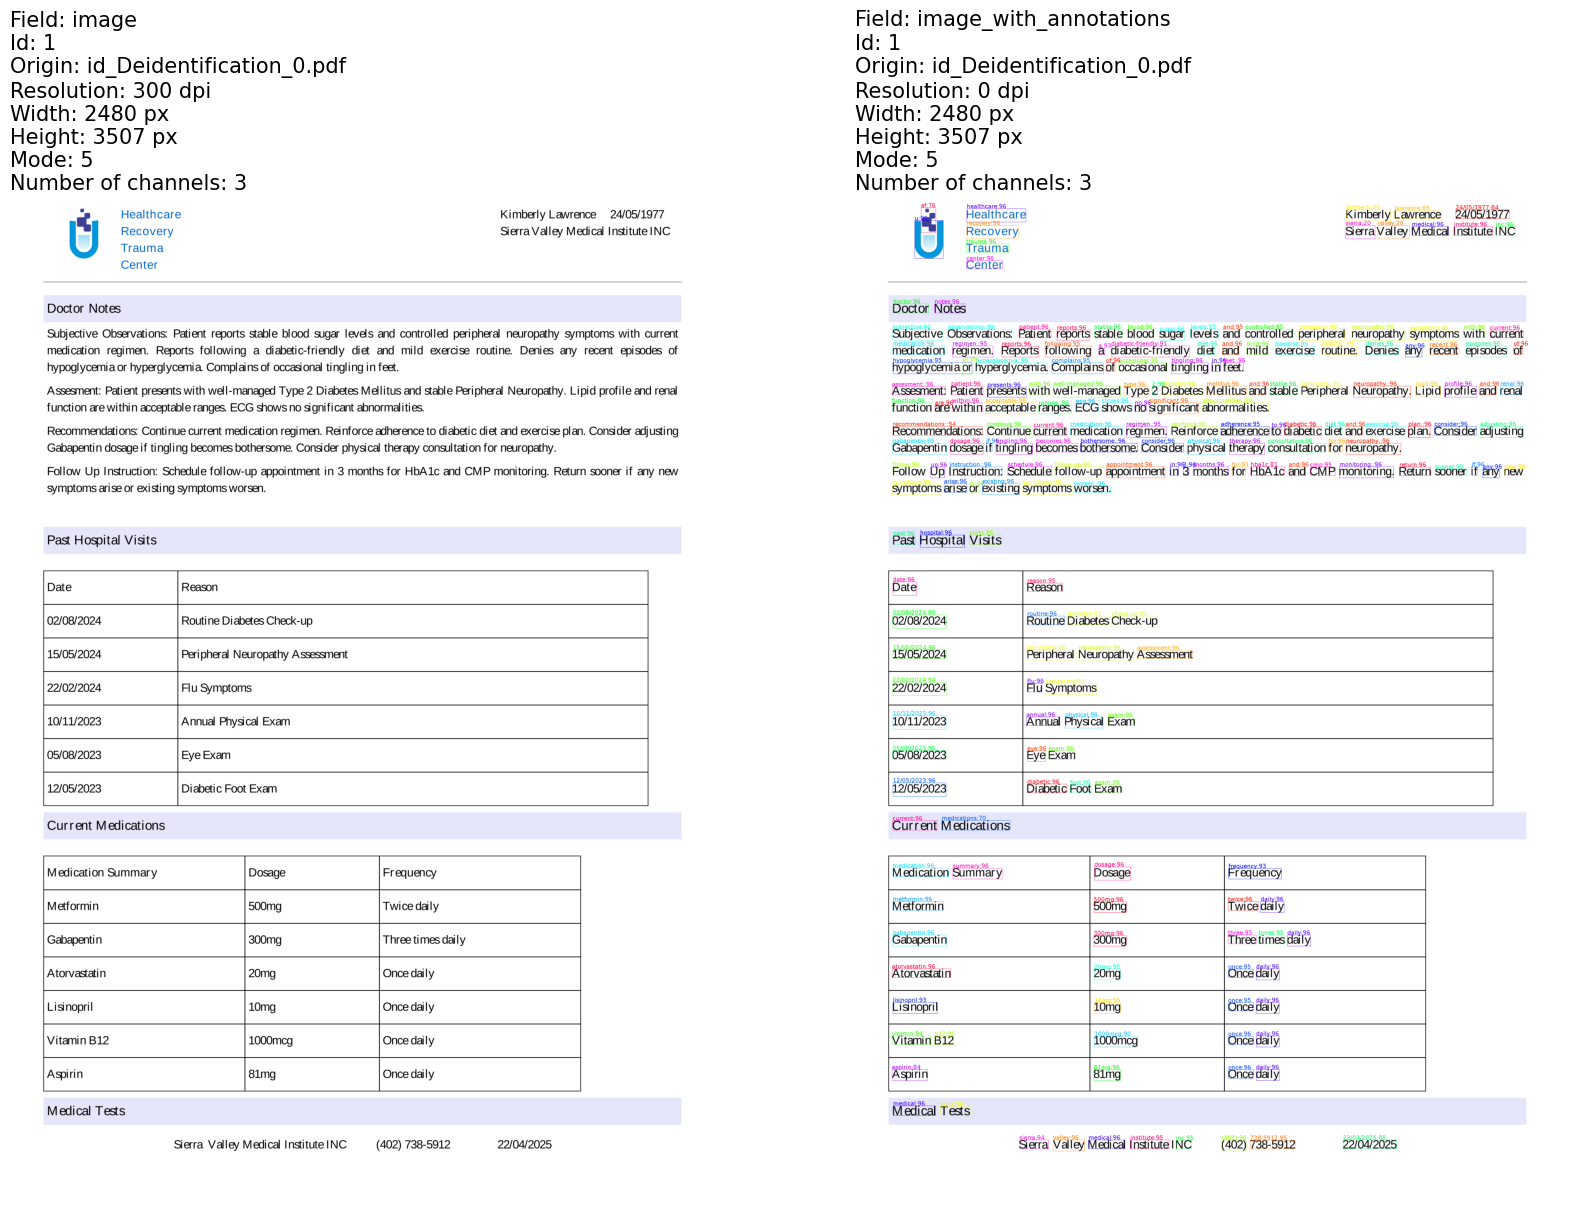

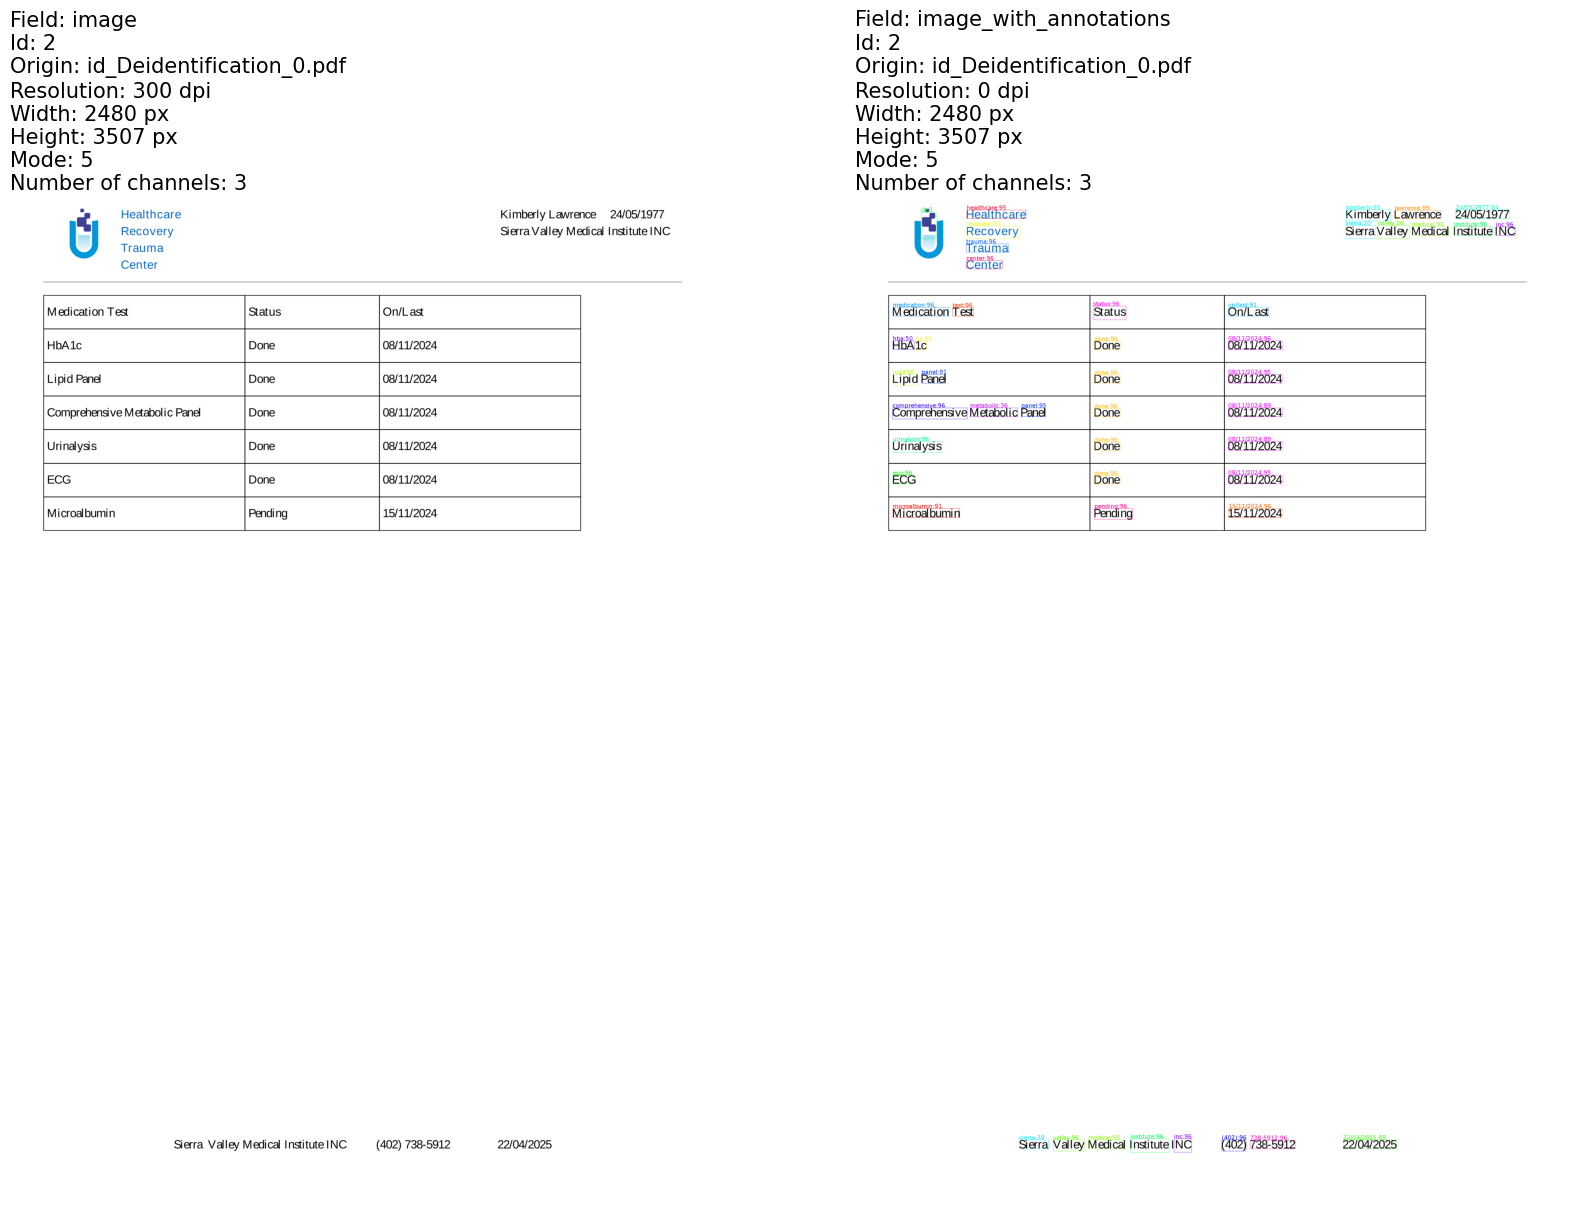

In [18]:
display_images_horizontal(result.orderBy("pagenum"), "image,image_with_annotations", width=1000, show_meta=True)

## ImageToTextV2 Parameters

**lineTolerance** – Used to group coordinates into lines and assemble the final text representation. It represents the pixel distance between two lines of text above which they are considered separate. Set to 0 to let the model automatically determine the best line tolerance for images with variable spacing.  
**maxImageRatio** – Maximum allowed width-to-height ratio of input images when grouping is enabled.  
**groupImages** – Specifies whether to group cropped images to maximize text detection quality.  
**batchSize** – Number of image patches processed simultaneously. Increase for faster GPU performance.  
**taskParallelism** – Number of threads used for processing a single region, controlling node-level parallelism.  
**useGPU** – Enables GPU acceleration for model inference.  
**useCaching** – Enables caching during the decoding stage for faster inference.  
**inputCols** – Name of the input column containing the image data.  
**regionsCol** – Column containing text region coordinates. If images are already split at word or line level, this can be set to null. 
**outputFormat** – Defines the output format of the detected text.  
**positionsCol** – Name of the output column containing text positions as PageMatrix objects.

<h1>ImageToTextV2 ( Printed ) - Using ImageTextDetector ( Scala )</h1>

In [19]:
pdf_to_image = PdfToImage() \
    .setInputCol("content") \
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR) \
    .setResolution(300)

text_detector = ImageTextDetector.pretrained("image_text_detector_mem_opt", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("text_regions") \
    .setScoreThreshold(0.7) \
    .setLinkThreshold(0.5) \
    .setWithRefiner(True) \
    .setTextThreshold(0.4) \
    .setSizeThreshold(-1) \
    .setUseGPU(True) \
    .setWidth(0)

ocr = ImageToTextV2.pretrained("ocr_base_printed_v2_opt", "en", "clinical/ocr") \
    .setRegionsColumn("text_regions") \
    .setInputCols(["image"]) \
    .setOutputCol("text") \
    .setOutputFormat("text_with_positions") \
    .setGroupImages(False) \
    .setKeepInput(True) \
    .setUseGPU(True) \
    .setUseCaching(True) \
    .setBatchSize(4)

draw_regions = ImageDrawRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("text_regions") \
    .setOutputCol("image_with_regions") \
    .setRectColor(Color.green)

v2_pdf_pipeline = PipelineModel(stages=[
    pdf_to_image,
    text_detector,
    ocr,
    draw_regions
])

image_text_detector_mem_opt download started this may take some time.
Approximate size to download 77.5 MB
image_text_detector_mem_opt download started this may take some time.
Approximate size to download 77.5 MB


25/10/22 19:07:42 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.
25/10/22 19:07:42 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


Download done! Loading the resource.


25/10/22 19:07:45 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.
25/10/22 19:07:45 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


ocr_base_printed_v2_opt download started this may take some time.
Approximate size to download 433 MB
Download done! Loading the resource.


In [20]:
result = v2_pdf_pipeline.transform(pdf_example_df).cache()
result.columns

['path',
 'modificationTime',
 'length',
 'image',
 'total_pages',
 'pagenum',
 'documentnum',
 'text_regions',
 'text',
 'confidence',
 'positions',
 'image_with_regions',
 'exception']

In [21]:
for item in result.orderBy("path", "pagenum").toLocalIterator():
  data = item.asDict()

  print(f"Pagenum : {data['pagenum']}", end="\n\n")

  print(data["text"], end="\n\n")

  print("--" * 50, end="\n\n")

25/10/22 19:08:23 WARN PDType1Font: Using fallback font LiberationSans for Helvetica-Bold
25/10/22 19:08:23 WARN PDType1Font: Using fallback font LiberationSans for Times-Roman
25/10/22 19:08:23 WARN PDType1Font: Using fallback font LiberationSans for Times-Bold
2025-10-22 19:08:28.172206917 [W:onnxruntime:, session_state.cc:1166 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2025-10-22 19:08:28.172223869 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
2025-10-22 19:08:28.187103978 [W:onnxruntime:, session_state.cc:1166 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns s

Pagenum : 0

HEALTHCARE KIMBERLY LAWRENCE 24/05/1977
RECOVERY SIERRA VALLEY MEDICAL INSTITUTE INC
U
TRAUMA
CENTER
PATIENT SUMMARY
K) "KEYLAYLAYMENT PRICEIP SALES, IS A KEYEXED FEMALE HER MEDICAL JUMEY INDAAS A DAYCASH T YE 2 DATETS
RECEIPTUS ACCORDARIES BY PERCHERA' MEXPANY, CURRENT TRANSACTION SEEON OF DAME CONDITIONED BY AND ITREASE
ADJUSTMENTS WITH REGULAR MONDING FOR FANTASY ADJESION OVER, THE PAINT BEHTS IS TAKE WITH ORGING
MANAGEMENT OF CHRONIC CONDITIONS.
PATIENT DEMOGRAPHICS
NAME: KIMBERLY
LAWRENCE
DOB: 24/05/1977
AGE: 46
SEX: FEMALE
SSN: 567-45-5412
HOSPITAL ID: HOSP26508961
PATIENT LIFESTYLE
SMOKING STATUS: NEVER
ALCOHOL CONSUMPTION: RARELY
DIEI PREFERENCE: DIABLEIC-FRIENOLY
EXERCISE HABITS: MILD
PATIENT VITALS
HEART RATE: 72
RESPIRATORY RATE: 16
TEMPERATURE CELSUS: 36.7
OXYGEN SATURATION PERCENT: 98
BLOOD PRESSURE: 130/85 MMHG
RECORDED DATE: 15/11/2024
DOCTOR INFORMATION
DOCTOR NAME:
CHERYL
BLANKENSHIP
DOCTOR UNIQUE ID:
DR14144B
SIERRA VALLEY MEDICAL INSTITUTE INC (402) 738-

[Stage 29:>                                                         (0 + 1) / 1]

Pagenum : 1

HEALTHCARE KIMBERLY LAWRENCE 24/05/1977
RECOVERY SIERRA VALLEY MEDICAL INSTITUTE INC
U
TRAUMA
CENTER
DOCTOR NOTES
SUBETIVE CHERATIONS PARANT RECE S/RE FOOD SEPS LEES AND CONDED FOR FACE IN EXPANY SHOPOTS WITH OR AT
RECEIPTATION REPORTS FOLLOWING A LABET CHIERBY DATE AND BEED BELLRE DATE DESPLAY REEM SPISCAS OF
HYPOGLYDEMIA OR HYPENGLYCEMIA COMPLAS OF OCCASIONAL TINGLING IN FET.
ASSERIENT: PALIER: TRANSACTION FACE - MARKAGET TYPE 2 DETAETES MELLIES AND EXCEIPTRA MEONDAY.LIP BYDATE AND RECE
FUNCTION ARE WITHIN ACCEPTABLE RANGES. ECG SHOWS NO SIGNIFICANT ABRONNAITIES.
RECOMMEXATIONS CONLINE AMOUNT RETURNABLE IN RECIPT FOR FACE OF ON FACEIND BY FACEBOOK FACE ON FACE AGAIN
GALAPENIN DESAGE IF INGLING RECONES DOLLERONE CONSIDE PAYSIA THEY DAY CONDITION FOR REQUIREDY.
FRIAN LPO INSTUR IN STRENDENPOIAPPRINT IN 3 MONIS IN HAD AND CUP PRINTING PERIN SCEIP BY
SYMPTOMS ARISE OR EXISTING SYMPTOMS WORSEN.
PAST HOSPITAL VISITS
DATE REASON
02/08/2024 ROUTINE DIABETES CHECK-UP
15/05/2024 P

<h1>ImageToTextV2 ( Handwritten ) - Using ImageTextDetector ( Scala )</h1>

In [22]:
image_path = "./data/visual/handwritten/iam_printed_example.png"

image_example_df = spark.read.format("binaryFile").load(image_path).cache()

image_example_df.columns

['path', 'modificationTime', 'length', 'content']

In [23]:
binary_to_image = BinaryToImage()\
    .setInputCol("content") \
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

text_detector = ImageTextDetector.pretrained("image_text_detector_mem_opt", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("text_regions") \
    .setScoreThreshold(0.7) \
    .setLinkThreshold(0.5) \
    .setWithRefiner(True) \
    .setTextThreshold(0.4) \
    .setSizeThreshold(-1) \
    .setUseGPU(True) \
    .setWidth(0)

ocr = ImageToTextV2.pretrained("ocr_large_handwritten_v2_opt", "en", "clinical/ocr") \
    .setRegionsColumn("text_regions") \
    .setInputCols(["image"]) \
    .setOutputCol("text") \
    .setOutputFormat("text_with_positions") \
    .setGroupImages(False) \
    .setKeepInput(True) \
    .setUseGPU(True) \
    .setUseCaching(True) \
    .setBatchSize(4)

draw_regions = ImageDrawRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("text_regions") \
    .setOutputCol("image_with_regions") \
    .setRectColor(Color.green)

v2_text_detection_handwritten_pipeline = PipelineModel(stages=[
    binary_to_image,
    text_detector,
    ocr,
    draw_regions
])

image_text_detector_mem_opt download started this may take some time.


25/10/22 19:09:14 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.
25/10/22 19:09:15 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


Approximate size to download 77.5 MB


25/10/22 19:09:15 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


ocr_large_handwritten_v2_opt download started this may take some time.
Approximate size to download 922.3 MB
Download done! Loading the resource.


In [24]:
result = v2_text_detection_handwritten_pipeline.transform(image_example_df).cache()
result.columns

['image',
 'path',
 'modificationTime',
 'length',
 'pagenum',
 'text_regions',
 'text',
 'confidence',
 'positions',
 'image_with_regions',
 'exception']

2025-10-22 19:09:52.131316146 [W:onnxruntime:, session_state.cc:1166 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2025-10-22 19:09:52.131340112 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
[Stage 32:>                                                         (0 + 1) / 1]


    Image #0:
    Origin: file:/workspace/spark-nlp-workshop/tutorials/Certification_Trainings/Training_Notebooks & Slides/Visual_NLP/data/visual/handwritten/iam_printed_example.png
    Resolution: 216 dpi
    Width: 716 px
    Height: 589 px
    Mode: 5
    Number of channels: 3


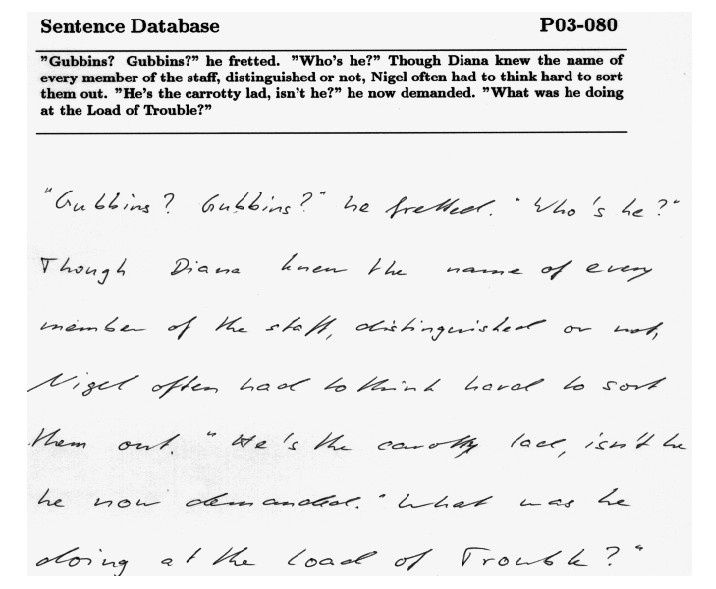

In [25]:
display_images(result, "image")

In [26]:
result.select("text").collect()[0].asDict()["text"].split("\n")

['Sentence Database p03-080',
 '" Gabbins ! Gubbins ! " he fretted . " Who\'s he ? " Though Diana knew the name of',
 'every member of the staff , distinguished or not , Nigel often had to think hard to sort',
 'them out . " He\'s the carrotty lad , isn\'t he ? " he now demanded . " What was he doing',
 'at the Load of Trouble ? "',
 'Gubbins ? Gubbins ? " he trelled . " Who\'s he ?',
 'Though dis a use . known the name of every',
 'member of the staff , distinguished or not ,',
 'Nigel often had to think hard to sort',
 "them . out . He's the country lace , isn't be",
 'he how down ended . What was she',
 "scosing . at the Load of Trowble ? '"]

<h1>ImageToTextV3 - ImageTextDetector ( Scala )</h1>

In [27]:
pdf_to_image = PdfToImage() \
    .setInputCol("content") \
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR) \
    .setResolution(300)

text_detector = ImageTextDetector.pretrained("image_text_detector_mem_opt", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("text_regions") \
    .setScoreThreshold(0.7) \
    .setLinkThreshold(0.5) \
    .setWithRefiner(True) \
    .setTextThreshold(0.4) \
    .setSizeThreshold(-1) \
    .setUseGPU(True) \
    .setWidth(0)

ocr = ImageToTextV3() \
    .setInputCols(["image", "text_regions"]) \
    .setOutputCol("text")

draw_regions = ImageDrawRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("text_regions") \
    .setOutputCol("image_with_regions") \
    .setRectColor(Color.green)

v3_text_detection_pdf_pipeline = PipelineModel(stages=[
    pdf_to_image,
    text_detector,
    ocr,
    draw_regions
])

image_text_detector_mem_opt download started this may take some time.
Approximate size to download 77.5 MB


25/10/22 19:10:38 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


In [28]:
result = v3_text_detection_pdf_pipeline.transform(pdf_example_df).cache()
result.columns

['path',
 'modificationTime',
 'length',
 'image',
 'total_pages',
 'pagenum',
 'documentnum',
 'text_regions',
 'text',
 'positions',
 'image_with_regions',
 'exception']

In [29]:
for item in result.orderBy("path", "pagenum").toLocalIterator():
  data = item.asDict()

  print(f"Pagenum : {data['pagenum']}", end="\n\n")

  print(data["text"], end="\n\n")

  print("--" * 50, end="\n\n")

25/10/22 19:10:45 WARN PDType1Font: Using fallback font LiberationSans for Helvetica-Bold
25/10/22 19:10:45 WARN PDType1Font: Using fallback font LiberationSans for Times-Roman
25/10/22 19:10:45 WARN PDType1Font: Using fallback font LiberationSans for Times-Bold
2025-10-22 19:10:46.837574992 [W:onnxruntime:, session_state.cc:1166 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2025-10-22 19:10:46.837609263 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
2025-10-22 19:10:46.932218482 [W:onnxruntime:, session_state.cc:1166 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns s

Pagenum : 0

Healthcare
 Kimberly Lawrence
 24/05/1977
 ig
 Recovery
 SierraValley Medical Institute INC
 Trauma
 Center
 Patient Summary
 Kimberly Lawrence, born on 24/05/1977, is a 46-year-old Female. Her medical journey indicates a diagnosis of Type 2 Diabetes
 Mellitus accompanied by Peripheral Neuropathy. Current management focuses on glycemic control through medication and lifestyle
 adjustments, with regular monitoring for neuropathy progression. Overall, the patient health status is stable with ongoing
 management of chronic conditions.
 Patient Demographics
 Name: Kimberly
 Lawrence
 DOB: 24/05/1977
 Age: 46
 Sex: Female
 SSN: 567-45-5412
 Hospital 1D: HOSP26508961
 Patient Lifestyle
 Smoking Status: Never
 Alcohol Consumption: Rarely
 Diet Preference: Diabetic-friendly
 Exercise Habits: Mild
 Patient Vitals
 Heart Rate: 72
 Respiratory Rate: 16
 Temperature Celsius: 36.7
 Oxygen Saturation Percent: 98
 Blood Pressure: 130/85 mmHg
 Recorded Date: 15/11/2024
 Doctor Information

[Stage 43:>                                                         (0 + 1) / 1]

Pagenum : 1

Healthcare
 Kimberly Lawrence
 24/05/1977
 ig
 Recovery
 SierraValley Medical Institute INC
 Trauma
 Center
 Doctor Notes
 Subjective Observations: Patient reports stable blood sugar levels and controlled peripheral neuropathy symptoms with current
 medication regimen. Reports following a diabetic-friendly diet and mild exercise routine. Denies any recent episodes of
 hypoglycemia or hyperglycemia. Complains of occasional tingling in feet.
 Assesment: Patient presents with well-managed Type 2 Diabetes Mellitus and stable Peripheral Neuropathy. Lipid profile and renal
 function are within acceptable ranges. ECG shows no significant abnormalities.
 Recommendations: Continue current medication regimen. Reinforce adherence to diabetic diet and exercise plan. Consider adjusting
 Gabapentin dosage if tingling becomes bothersome. Consider physical therapy consultation for neuropathy.
 Follow Up Instruction: Schedule follow-up appointment in 3 months for HbA1c and CMP monitoring. 

<h1>ImageToTextV2 and ImageToTextV3 Output Formats</h1>

<p>
  Both <code>ImageToTextV2</code> and <code>ImageToTextV3</code> support the same set of output formats:
</p>

<ul>
  <li>TEXT_WITH_POSITIONS</li>
  <li>TEXT</li>
  <li>FORMATTED_TEXT</li>
  <li>HOCR</li>
</ul>

In [30]:
v3_text_detection_pdf_pipeline.stages[2].extractParamMap()

{Param(parent='ImageToTextV3_4a2a825bcffa', name='outputCol', doc='output column name.'): 'text',
 Param(parent='ImageToTextV3_4a2a825bcffa', name='margin', doc='Margin for the text regions'): -2,
 Param(parent='ImageToTextV3_4a2a825bcffa', name='outputFormat', doc='Output format for the returned text, can be one of {OcrOutputFormat.TEXT, OcrOutputFormat.FORMATTED_TEXT, OcrOutputFormat.HOCR}'): 'text',
 Param(parent='ImageToTextV3_4a2a825bcffa', name='inputCols', doc='input column names.'): ['image',
  'text_regions']}

In [31]:
v3_text_detection_pdf_pipeline.stages[2].setOutputFormat(OcrOutputFormat.FORMATTED_TEXT)

result = v3_text_detection_pdf_pipeline.transform(pdf_example_df)
result.columns

['path',
 'modificationTime',
 'length',
 'image',
 'total_pages',
 'pagenum',
 'documentnum',
 'text_regions',
 'text',
 'positions',
 'image_with_regions',
 'exception']

In [32]:
for item in result.orderBy("path", "pagenum").toLocalIterator():
  data = item.asDict()

  print(f"Pagenum : {data['pagenum']}", end="\n\n")

  print(data["text"], end="\n\n")

  print("--" * 50, end="\n\n")

25/10/22 19:11:28 WARN PDType1Font: Using fallback font LiberationSans for Helvetica-Bold
25/10/22 19:11:28 WARN PDType1Font: Using fallback font LiberationSans for Times-Roman
25/10/22 19:11:28 WARN PDType1Font: Using fallback font LiberationSans for Times-Bold
2025-10-22 19:11:28.932018360 [W:onnxruntime:, session_state.cc:1166 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2025-10-22 19:11:28.932041367 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
2025-10-22 19:11:29.048883148 [W:onnxruntime:, session_state.cc:1166 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns s

Pagenum : 0

                   Healthcare
                                                            Kimberly Lawrence
  24/05/1977
 ig
 Recovery
 SierraValley Medical Institute INC
 Trauma
 Center
 Patient Summary
 Kimberly Lawrence, born on 24/05/1977, is a 46-year-old Female. Her medical journey indicates a diagnosis of Type 2 Diabetes
 Mellitus accompanied by Peripheral Neuropathy. Current management focuses on glycemic control through medication and lifestyle
 adjustments, with regular monitoring for neuropathy progression. Overall, the patient health status is stable with ongoing
 management of chronic conditions.
 Patient Demographics
 Name: Kimberly
 Lawrence
 DOB: 24/05/1977
 Age: 46
 Sex: Female
 SSN: 567-45-5412
 Hospital 1D: HOSP26508961
 Patient Lifestyle
 Smoking Status: Never
 Alcohol Consumption: Rarely
 Diet Preference: Diabetic-friendly
 Exercise Habits: Mild
 Patient Vitals
 Heart Rate: 72
 Respiratory Rate: 16
 Temperature Celsius: 36.7
 Oxygen Saturation Percent:

[Stage 54:>                                                         (0 + 1) / 1]

Pagenum : 1

                   Healthcare
                                                            Kimberly Lawrence
  24/05/1977
 ig
 Recovery
 SierraValley Medical Institute INC
 Trauma
 Center
 Doctor Notes
 Subjective Observations: Patient reports stable blood sugar levels and controlled peripheral neuropathy symptoms with current
 medication regimen. Reports following a diabetic-friendly diet and mild exercise routine. Denies any recent episodes of
 hypoglycemia or hyperglycemia. Complains of occasional tingling in feet.
 Assesment: Patient presents with well-managed Type 2 Diabetes Mellitus and stable Peripheral Neuropathy. Lipid profile and renal
 function are within acceptable ranges. ECG shows no significant abnormalities.
 Recommendations: Continue current medication regimen. Reinforce adherence to diabetic diet and exercise plan. Consider adjusting
 Gabapentin dosage if tingling becomes bothersome. Consider physical therapy consultation for neuropathy.
 Follow Up Instruc

In [38]:
v3_text_detection_pdf_pipeline.stages[2].extractParamMap()

{Param(parent='ImageToTextV3_4a2a825bcffa', name='outputCol', doc='output column name.'): 'text',
 Param(parent='ImageToTextV3_4a2a825bcffa', name='margin', doc='Margin for the text regions'): -2,
 Param(parent='ImageToTextV3_4a2a825bcffa', name='outputFormat', doc='Output format for the returned text, can be one of {OcrOutputFormat.TEXT, OcrOutputFormat.FORMATTED_TEXT, OcrOutputFormat.HOCR}'): <OcrOutputFormat.FORMATTED_TEXT: 'formatted_text'>,
 Param(parent='ImageToTextV3_4a2a825bcffa', name='inputCols', doc='input column names.'): ['image',
  'text_regions']}

In [39]:
v3_text_detection_pdf_pipeline.stages[2].setOutputFormat(OcrOutputFormat.HOCR).setOutputCol("hocr")

result = v3_text_detection_pdf_pipeline.transform(pdf_example_df)
result.columns

['path',
 'modificationTime',
 'length',
 'image',
 'total_pages',
 'pagenum',
 'documentnum',
 'text_regions',
 'hocr',
 'positions',
 'image_with_regions',
 'exception']

In [40]:
result.select("hocr").show(10, True)

25/10/22 19:12:56 WARN PDType1Font: Using fallback font LiberationSans for Helvetica-Bold
25/10/22 19:12:56 WARN PDType1Font: Using fallback font LiberationSans for Times-Roman
25/10/22 19:12:56 WARN PDType1Font: Using fallback font LiberationSans for Times-Bold
2025-10-22 19:12:56.945419561 [W:onnxruntime:, session_state.cc:1166 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2025-10-22 19:12:56.945443390 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
2025-10-22 19:12:56.965205723 [W:onnxruntime:, session_state.cc:1166 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns s

+--------------------+
|                hocr|
+--------------------+
|<div title="bbox ...|
|<div title="bbox ...|
|<div title="bbox ...|
+--------------------+

